##CNN-2D и CNN-2D + LSTM + STFT + CWT

In [ ]:
#安装pywavelets库用于小波变换
!pip install pywavelets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 89.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.signal import spectrogram
import pywt
import cv2
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPool2D, Flatten, Dense, Dropout,
                          TimeDistributed, LSTM)
from keras.optimizers import Adam
from keras import backend as K

In [ ]:
# 从GitHub加载训练/测试数据和标签
x_train = pd.read_csv("https://github.com/TAUforPython/BioMedAI/blob/main/test_datasets/MI-EEG-B9T.csv?raw=true",header=None)
x_test = pd.read_csv("https://github.com/TAUforPython/BioMedAI/blob/main/test_datasets/MI-EEG-B9E.csv?raw=true",header=None)
y_train = pd.read_csv("https://github.com/TAUforPython/BioMedAI/blob/main/test_datasets/2class_MI_EEG_train_9.csv?raw=true",header=None)
y_test = pd.read_csv("https://github.com/TAUforPython/BioMedAI/blob/main/test_datasets/2class_MI_EEG_test_9.csv?raw=true",header=None)

数据来源为PhysioNet的EEG运动想象数据集，目标是对左右手运动想象进行分类（二分类问题）

数据集已预分割为训练集（B9T）和测试集（B9E），标签为0（左手）和1（右手）



In [ ]:
# 数据维度检查
print(x_train.shape)# 输出：(样本数, 时序信号长度)
print(x_test.shape)
print(y_train.shape)# 输出：(样本数, 1)；二分类标签
print(y_test.shape)

(400, 3000)
(320, 3000)
(400, 1)
(320, 1)


In [ ]:
n_samples_train = len(y_train) #训练集样本数量
n_samples_test = len(y_test) #测试集样本数量

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 400
n_samples_test : 320


In [ ]:
# count classes
# 提取测试集标签中的所有唯一值
n_classes = len(np.unique(y_test))

print("n_classes:", n_classes)

n_classes: 2


说明对应的是二分类任务。

data: 输入数据矩阵，形状为 (样本数, 通道数×时序长度)

fs: 采样率（单位：Hz），典型EEG采样率为250Hz

alto: 输出谱图的总高度（像素）

ancho: 输出谱图的宽度（时间维度）

n_canales: 通道数（如EEG的C3/Cz/C4为3通道）

pts_sig: 单通道信号长度（时序点数）

pts_superpuestos: STFT窗口重叠点数

In [ ]:
# calculate STFT
# STFT特征提取函数

def spectrogram_vertical(data, fs, alto, ancho, n_canales, pts_sig,
                                 pts_superpuestos):
  #fs = fs #frecuencia de muestreo
  datesets = np.zeros((data.shape[0],alto, ancho)) # 存储所有样本的谱图，维度为 (样本数, 高度, 宽度)

  # crear matriz 2D donde se guardara cada imagen del STFT
  temporal = np.zeros((alto, ancho)) #临时存储单个样本的多通道拼接谱图

  for i in range(data.shape[0]): # n muestras # 遍历每个样本
    for j in range(n_canales): # n canales # 遍历每个通道

      sig = data.iloc[i, j*pts_sig:(j+1)*pts_sig] # 信号切片，如pts_sig=1000，则每个通道1000个数据

      # stft计算
      f, t, Sxx = spectrogram(sig, fs=fs, window='hann', nperseg=fs, # 窗口长度=采样率 → 1秒窗口
                              noverlap=pts_superpuestos, # 重叠点数
                              nfft=fs*2, # FFT点数=2倍窗口长度
                              scaling='spectrum') # 功率谱密度

      # concatenacion vertical chanels
      temporal[j*45:(j+1)*45, :] = Sxx[16:61, :] # 谱图截取与拼接

    datesets[i] = temporal # 结果存储
    if i % 100 == 0:
      print(i)
  return datesets

In [ ]:
# calculate scalogram CWT
# CWT特征提取函数

def scalogram_vertical(data, fs, alto, ancho, n_canales, pts_sig):
  dim = (int(np.floor(ancho/2)), int(np.floor(alto/2))) # ancho, alto 将原始特征图尺寸减半

  # Wavelet Morlet 3-3
  # frequency 8 - 30 Hz
  scales = pywt.scale2frequency('cmor3-3', np.arange(8,30.5,0.5)) / (1/fs) # 小波参数设置

  datesets = np.zeros((data.shape[0], int(np.floor(alto/2)), # 存储最终降采样后的特征图
                    int(np.floor(ancho/2))))

  temporal = np.zeros((alto, ancho)) # 临时存储原始尺度图

  for i in range(data.shape[0]): # 遍历样本
    for j in range(n_canales): # 遍历通道

      sig = data.iloc[i, j*pts_sig:(j+1)*pts_sig] # 通道信号提取

      coef, freqs = pywt.cwt(sig, scales, 'cmor3-3', # CWT计算
                             sampling_period = (1 / fs))

      temporal[j*45:(j+1)*45, :] = abs(coef) # 垂直堆叠

    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datesets[i] = resized
    if i % 100 == 0:
      print(i)
  return datesets

In [ ]:
# 特征工程
initial = time.time() # 记录开始时间

# STFT 执行STFT特征提取
x_train = spectrogram_vertical(x_train, 250, 135, 31, 3, 1000, 225)
x_test = spectrogram_vertical(x_test, 250, 135, 31, 3, 1000, 225)

# CWT
#x_train = scalogram_vertical(x_train, 250, 135, 1000, 3, 1000)
#x_test = scalogram_vertical(x_test, 250, 135, 1000, 3, 1000)

fin = time.time()
print("time_elapsed:", fin - initial)

0
100
200
300
0
100
200
300
time_elapsed: 2.4822096824645996


In [ ]:
#*****
# 特征工程
initial = time.time() # 记录开始时间
# CWT
x_train = scalogram_vertical(x_train, 250, 135, 1000, 3, 1000)
x_test = scalogram_vertical(x_test, 250, 135, 1000, 3, 1000)

fin = time.time()
print("time_elapsed:", fin - initial)



0
100
200
300
0
100
200
300
time_elapsed: 50.96474313735962


In [ ]:
# (样本数, 频率通道, 时间帧)
print(x_train.shape)
print(x_test.shape)

(400, 67, 500)
(320, 67, 500)


In [ ]:
# 计算数据集的最大值，用于归一化处理
x = np.ceil(np.max(x_train))

In [ ]:
# convert to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# 归一化处理
x_train /= x
x_test /= x

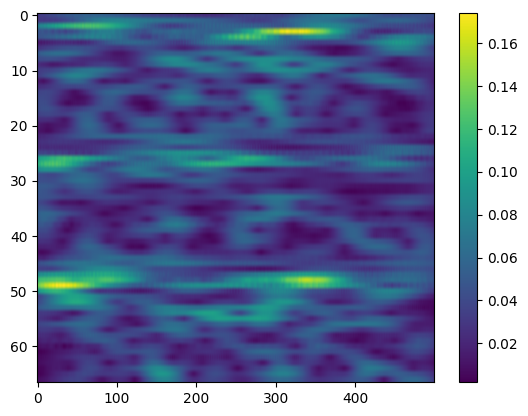

In [ ]:
# 可视化训练集中的第一个样本的时频特征图
plt.figure() # 创建新画布
plt.imshow(x_train[1],  aspect='auto') # 绘制训练集第2个样本（索引从0开始）；自动调整宽高比
plt.colorbar() # 添加颜色刻度条
plt.show() # 显示图像

In [ ]:
#  reshape a 4D (for CNN-2D)
# 目标形状: (样本数, 高, 宽, 通道数)
#x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
#x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

# convert  3D to 5D (CNN-2D + LSTM)
# 目标形状: (样本数, 时间步, 高, 宽, 通道数)
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(400, 1, 135, 31, 1)
(320, 1, 135, 31, 1)


In [ ]:
#***********
#  reshape a 4D (for CNN-2D)
# 目标形状: (样本数, 高, 宽, 通道数)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)



(400, 67, 500, 1)
(320, 67, 500, 1)


In [ ]:
# crear red neuronal CNN-2D

def CNN_2D(num_filter, size_filter, n_neurons):
  model = Sequential()
  model.add(Conv2D(num_filter, size_filter, activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2))) # 池化层；输出尺寸减半
  model.add(Conv2D(num_filter, size_filter, activation='relu', padding='same'))
  model.add(MaxPool2D((2,2))) # 二次池化；输出尺寸减半
  model.add(Flatten())
  model.add(Dense(n_neurons, activation='relu'))
  model.add(Dropout(0.5)) # 随机丢弃50%神经元
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(learning_rate=0.001) #优化器配置
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy', # 损失函数
                metrics = ['accuracy'])
  return model

In [ ]:
# crear red neuronal CNN-2D + LSTM

def CNN_2D_LSTM_TD(num_filter, size_filter, n_neurons, units_LSTM):
  model = Sequential()
  model.add(TimeDistributed(Conv2D(num_filter, size_filter, activation='relu',
                                   padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2)))) # 池化层；输出尺寸减半
  model.add(TimeDistributed(Conv2D(num_filter, size_filter, activation='relu',
                                   padding='same')))
  model.add(TimeDistributed(MaxPool2D((2,2)))) # 二次池化；输出尺寸减半
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(units_LSTM, activation='tanh', dropout=0.5))
  model.add(Dense(n_neurons, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(learning_rate=1e-3) # 学习率设置
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model


In [ ]:
initial = time.time()  # 记录开始时间
array_loss = []        # 存储每次实验的测试损失
array_acc = []         # 存储每次实验的测试准确率
array_kappa = []       # 预留的Kappa系数存储（代码中未使用）
for i in range(5):
  print("Iteration:", i+1) # 显示当前实验轮次


  #model = CNN_2D(4, (3,3), 32)
  model = CNN_2D_LSTM_TD(4, (3,3), 32, 4) # 创建CNN-LSTM混合模型（卷积滤波器数量，卷积核尺寸，全连接层神经元数，LSTM单元数）

 # history = model.fit(x_train, y_train, epochs=40, batch_size=36,
 #                     validation_data=(x_test, y_test), verbose=0)

  history = model.fit(x_train, y_train, epochs=70, batch_size=36, # 训练70轮 # 每批36个样本
                       validation_split = 0.1, verbose=0) # 10%训练数据作验证集 # 不显示进度条

  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)

Iteration: 1


NameError: name 'CNN_2D_LSTM_TD' is not defined

In [ ]:
#****************
initial = time.time()  # 记录开始时间
array_loss = []        # 存储每次实验的测试损失
array_acc = []         # 存储每次实验的测试准确率
array_kappa = []       # 预留的Kappa系数存储（代码中未使用）
for i in range(5):
  print("Iteration:", i+1) # 显示当前实验轮次

  model = CNN_2D(4, (3,3), 32)

  history = model.fit(x_train, y_train, epochs=70, batch_size=36,
                      validation_data=(x_test, y_test), verbose=0)

  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)

Iteration: 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


loss:  0.8150410652160645
accuracy:  0.762499988079071
Iteration: 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


loss:  0.4788421094417572
accuracy:  0.793749988079071
Iteration: 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


loss:  0.595064103603363
accuracy:  0.768750011920929
Iteration: 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


loss:  0.5898177623748779
accuracy:  0.793749988079071
Iteration: 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


loss:  0.636670708656311
accuracy:  0.796875


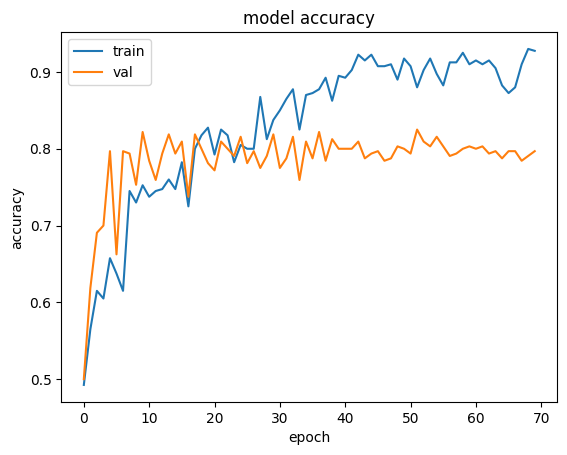

In [ ]:
plt.plot(history.history['accuracy'])       # 绘制训练准确率曲线，曲线越高表示拟合能力越强
plt.plot(history.history['val_accuracy'])  # 绘制验证准确率曲线，衡量泛化能力
plt.title('model accuracy')                # 设置标题
plt.ylabel('accuracy')                     # 设置Y轴标签
plt.xlabel('epoch')                        # 设置X轴标签
plt.legend(['train', 'val'], loc='upper left') # 添加图例
plt.show()                                 # 显示图形

In [ ]:
probabilidades = model.predict(x_test) # 获取预测概率矩阵

y_pred = np.argmax(probabilidades, 1) # 取概率最大的类别

  # calculate kappa cohen
kappa = cohen_kappa_score(y_test, y_pred) # 计算一致性系数
array_kappa.append(kappa)
print("kappa: ", kappa)
matriz_confusion = confusion_matrix(y_test, y_pred) # 混淆矩阵生成
print("confusion matrix:\n", matriz_confusion)


#Интерпретация
#(\kappa = 1): Полное согласие, модель идеально предсказывает все классы.
#(\kappa = 0): Согласие на уровне случайного угадывания.
#(\kappa < 0): Согласие хуже, чем случайное угадывание.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
kappa:  0.59375
confusion matrix:
 [[143  17]
 [ 48 112]]


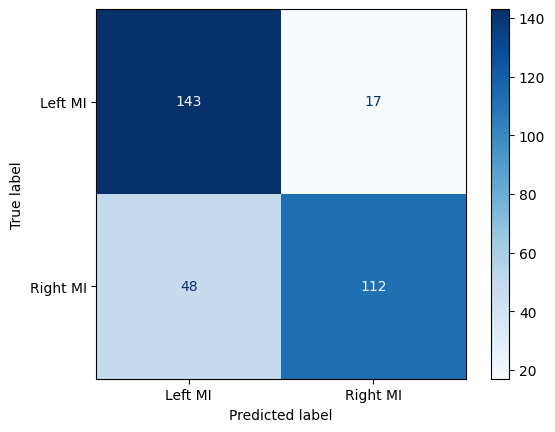

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay # 导入Scikit-learn提供的混淆矩阵可视化类

labels = ["Left MI", "Right MI"] # 定义类别标签

disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=labels) # 创建显示对象

disp.plot(cmap=plt.cm.Blues) #绘制热力图
plt.show()

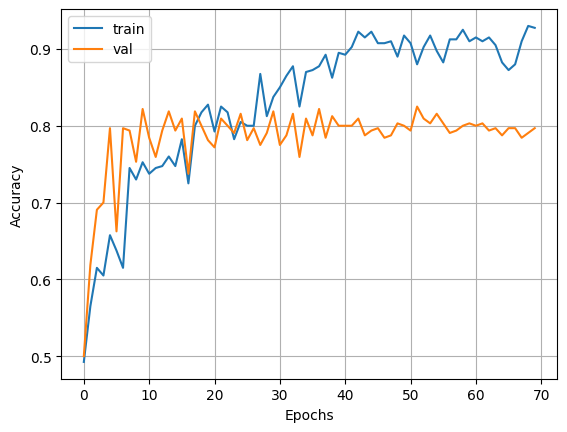

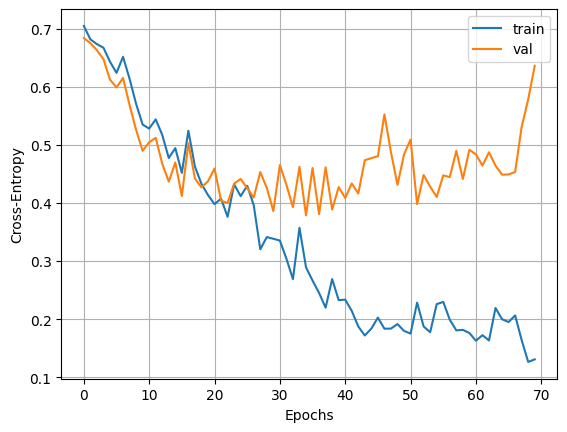


Resultados:
loss: [0.8150410652160645, 0.4788421094417572, 0.595064103603363, 0.5898177623748779, 0.636670708656311]
accuracy: [0.762499988079071, 0.793749988079071, 0.768750011920929, 0.793749988079071, 0.796875]
kappa: [np.float64(0.59375)]
time_elapsed: 133.9856903553009


In [ ]:
  # 训练过程可视化
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'val'])
  plt.show()
  # 损失曲线绘制
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'val'])
  plt.show()
# 实验结果汇总
print()
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
fin = time.time()
time_elapsed = fin - initial
print("time_elapsed:", time_elapsed)

In [ ]:
model.summary() #展示模型的层架构、参数数量及维度变化

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 67, 500, 4)     │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 33, 250, 4)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 33, 250, 4)     │           148 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 125, 4)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │       256,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 768,860 (2.93 MB)

 Trainable params: 256,286 (1001.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 512,574 (1.96 MB)

In [ ]:
print("Mean Accuracy: %.4f" % np.mean(array_acc)) # 平均准确率
print("std: (+/- %.4f)" % np.std(array_acc)) # 准确率标准差
print("Mean Kappa: %.4f" % np.mean(array_kappa)) # 平均Kappa
print("std: (+/- %.4f)" % np.std(array_kappa))  # Kappa标准差
print("Max Accuracy: %.4f" % np.max(array_acc)) # 最佳准确率
print("Max Kappa: %.4f" % np.max(array_kappa)) # 最佳Kappa
print("time_elapsed:", int(time_elapsed)) # 总耗时（秒）

Mean Accuracy: 0.7831
std: (+/- 0.0145)
Mean Kappa: 0.5938
std: (+/- 0.0000)
Max Accuracy: 0.7969
Max Kappa: 0.5938
time_elapsed: 133
